**Student:** Masharina Elizaveta

#### Task 1

Dataset - Instacart https://www.kaggle.com/c/instacart-market-basket-analysis/data (use this data for all tasks below)

EDA (2 points):
- Investigation of tables and mapping between them
- Distribution of users/ products/ orders
- Popularity of products/categories
- Existence of dummy products

Metrics (1 point): 
- MAP@k
- HitRate@k
- NDCG@k

Models (7 points):
- Most popular recommender (1 point)
- SVD based recommender (3 points)
- Neural Network recommender which has 2 embedding layers for user and item and calculates the score as the dot product. Fully-connected layers can be incorporated as well to improve the model's expressiveness. (3 points)

Optional models (6 points): 
- Nearest Neighbor recommender utilizing SVD embeddings and annoy library for fast neighbors search (2 points). 
- ALS recommender from the implicit library (2 points).
- Gradient boosting recommender utilizing SVD embedding (2 points).

Total - 10 points + 6 extra points

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
import os
import implicit
import random
import annoy

from scipy.sparse import csc_matrix, csr_matrix
from sparsesvd import sparsesvd
from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
from annoy import AnnoyIndex

## Utils

In [ ]:
def hit_rate_one(ground_truth, recommendation, k):
    if len(list(set(ground_truth) & set(recommendation[:k]))) != 0:
        return 1
    return 0

In [ ]:
def hit_rate(ground_truth, recommendation, k):
    return sum([hit_rate_one(ground_truth[i], recommendation[i], k) for i in range(len(recommendation))]) / len(recommendation)

In [ ]:
def get_binary_relevance(ground_truth, recomendation):
    relevance = []
    for i in range(len(recomendation)):
        if recomendation[i] in ground_truth:
            relevance.append(1)
        else:
            relevance.append(0)
    return relevance

In [ ]:
def precision(recommendation, k):
    return sum(recommendation[:k]) / k

In [ ]:
def AP(ground_truth, recommendation, k):
    if k > len(recommendation):
        k = len(recommendation)
    relevance = get_binary_relevance(ground_truth, recommendation)
    if sum(relevance[:k]) == 0:
        return 0
    return sum([relevance[i] * precision(relevance, i + 1) for i in range(k)]) / sum(relevance[:k])

In [ ]:
def MAP(ground_truth, recommendation, k):
    return sum([AP(ground_truth[i], recommendation[i], k) for i in range(len(recommendation))]) / len(recommendation)

In [ ]:
def DCG_one(ground_truth, recommendation, k):
    if k > len(recommendation):
        k = len(recommendation)
    relevance = get_binary_relevance(ground_truth, recommendation)
    return sum([(2 ** relevance[i] - 1) / (math.log2(i + 2)) for i in range(k)])

In [ ]:
def best_DCG_one(ground_truth, recommendation, k):
    if k > len(ground_truth):
        relevance = [1] * len(ground_truth) + [0] * (k - len(ground_truth))
    else:
        relevance = [1] * k
    return sum([(2 ** relevance[i] - 1) / (math.log2(i + 2)) for i in range(k)])

In [ ]:
def NDCG_one(ground_truth, recommendation, k):
    return DCG_one(ground_truth, recommendation, k) / best_DCG_one(ground_truth, recommendation, k)

In [ ]:
def NDCG(ground_truth, recommendation, k):
    return sum([NDCG_one(ground_truth[i], recommendation[i], k) for i in range(len(recommendation))]) / len(recommendation)

In [ ]:
def print_metrics(ground_truth, recommendation, k):
    df = pd.DataFrame({'metric': ['HitRate@k', 'MAP@k', 'NDCG@k'], 
                       'value': [hit_rate(ground_truth, recommendation, k),
                                 MAP(ground_truth, recommendation, k),
                                 NDCG(ground_truth, recommendation, k)]})
    print(df)

## Read data

In [ ]:
# aisles = pd.read_csv('/content/drive/MyDrive/EPAM RecSys/data/aisles.csv') # торговый ряд (готовые салаты, сыры, батончики)
# departments = pd.read_csv('/content/drive/MyDrive/EPAM RecSys/data/departments.csv') # отдел (заморозка, пекарня, другое) 
# orders = pd.read_csv('/content/drive/MyDrive/EPAM RecSys/data/orders.csv') # к какому набору относится заказ (prior, train, test)
# products = pd.read_csv('/content/drive/MyDrive/EPAM RecSys/data/products.csv') # продукты
# order_products__prior = pd.read_csv('/content/drive/MyDrive/EPAM RecSys/data/order_products__prior.csv') # продукты в предыдущем заказе
# order_products__train = pd.read_csv('/content/drive/MyDrive/EPAM RecSys/data/order_products__train.csv') # продукты в тренировочном заказе

In [ ]:
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
order_products__prior = pd.read_csv('data/order_products__prior.csv') 
order_products__train = pd.read_csv('data/order_products__train.csv')

## EDA

### Check all data

#### aisles

In [ ]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


134 элемента.

In [ ]:
aisles.isna().sum()

aisle_id    0
aisle       0
dtype: int64

Нет пропусков.

In [ ]:
len(pd.unique(aisles['aisle']))

134

Все значения уникальны.

#### departments

In [ ]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


21 элемент.

In [ ]:
departments.isna().sum()

department_id    0
department       0
dtype: int64

Нет пропусков.

In [ ]:
len(pd.unique(departments['department']))

21

Все значения уникальны.

#### orders

In [ ]:
orders.head()
# order_dow - день недели

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
orders = orders.sort_values(by=['user_id', 'order_number'])
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [ ]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [ ]:
orders.duplicated().sum()

0

Все значения уникальны.

In [ ]:
orders.groupby(['user_id']).count().sort_values(by=['order_id'])['order_id']

user_id
127633      4
74147       4
160570      4
160560      4
74171       4
         ... 
1868      100
31118     100
122476    100
120897    100
26086     100
Name: order_id, Length: 206209, dtype: int64

206209 пользователей есть в базе. Пользователи совершали от 4 до 100 заказов.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb63bc4470>,
      dtype=object)

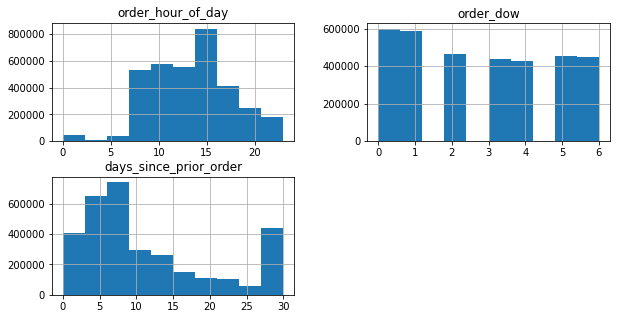

In [ ]:
orders[['order_hour_of_day', 'order_dow', 'days_since_prior_order']].hist(figsize=(10, 5))

Продукты заказываются, в основном, днём - с 7-8 утра, до 21. Наиболее часто - в районе обеда, в 15.  
Чаще всего продукты заказывают примерно раз в неделю, но бывает и раз в месяц. 

In [ ]:
orders[['order_hour_of_day', 'order_dow', 'days_since_prior_order']].describe()

,order_hour_of_day,order_dow,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.345202e+01,2.776219e+00,1.111484e+01
std,4.226088e+00,2.046829e+00,9.206737e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+01,1.000000e+00,4.000000e+00
50%,1.300000e+01,3.000000e+00,7.000000e+00
75%,1.600000e+01,5.000000e+00,1.500000e+01
max,2.300000e+01,6.000000e+00,3.000000e+01


#### products

In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
products.duplicated().sum()

0

Все значения уникальны.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb636aceb8>,
      dtype=object)

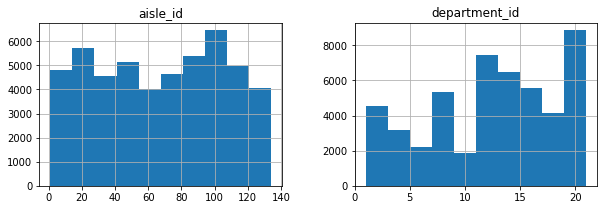

In [ ]:
products[['aisle_id', 'department_id']].hist(figsize=(10, 3))

In [ ]:
products.groupby(by=['aisle_id']).count()['product_id'].describe()

count     134.000000
mean      370.805970
std       267.010165
min        12.000000
25%       179.750000
50%       305.500000
75%       497.500000
max      1258.000000
Name: product_id, dtype: float64

В каждом торговом ряду представлено от 12 до 1258 видов товаров, в среднем - 370. 

In [ ]:
products.groupby(by=['department_id']).count()['product_id'].describe()

count      21.000000
mean     2366.095238
std      1914.367491
min        38.000000
25%      1081.000000
50%      1516.000000
75%      3449.000000
max      6563.000000
Name: product_id, dtype: float64

В каждом отделе представлено от 38 до 6563 видов товаров, в среднем - 2366.

#### order_products__prior

In [ ]:
order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
order_products__prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [ ]:
order_products__prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [ ]:
order_products__prior.duplicated().sum()

0

Все значения уникальны.

In [ ]:
order_products__prior.groupby(['order_id']).count()

,product_id,add_to_cart_order,reordered
order_id,,,
2,9,9,9
3,8,8,8
4,13,13,13
5,26,26,26
6,3,3,3
...,...,...,...
3421079,1,1,1
3421080,9,9,9
3421081,7,7,7


#### order_products__train

In [ ]:
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
order_products__train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [ ]:
order_products__train.duplicated().sum()

0

Все значения уникальны.

In [ ]:
order_products__train.groupby(['order_id']).count()

,product_id,add_to_cart_order,reordered
order_id,,,
1,8,8,8
36,8,8,8
38,9,9,9
96,7,7,7
98,49,49,49
...,...,...,...
3421049,6,6,6
3421056,5,5,5
3421058,8,8,8


### Data preparation, train / test split

Все заказы я разделила на 2 набора: для обучения и для теста.    
Тестовый набор: последний заказ каждого пользователя.

In [ ]:
orders_available = orders[orders['eval_set'] != 'test']
orders_available.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
order_id_test = orders_available.groupby(by=['user_id']).last()['order_id'].values
order_id_test, len(order_id_test)

(array([1187899, 1492625, 1402502, ..., 1005822, 1882108,  272231],
       dtype=int64), 206209)

In [ ]:
orders_available['eval_set'] = 'TRAIN'
orders_available.loc[orders_available['order_id'].isin(order_id_test), 'eval_set'] = 'TEST'
orders_available.head()

C:\Users\coffe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\coffe\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,TRAIN,1,2,8,NaN
1,2398795,1,TRAIN,2,3,7,15.0
2,473747,1,TRAIN,3,3,12,21.0
3,2254736,1,TRAIN,4,4,7,29.0
4,431534,1,TRAIN,5,4,15,28.0


In [ ]:
orders_available['eval_set'].unique()

array(['TRAIN', 'TEST'], dtype=object)

In [ ]:
orders_available.head(26)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,TRAIN,1,2,8,NaN
1,2398795,1,TRAIN,2,3,7,15.0
2,473747,1,TRAIN,3,3,12,21.0
3,2254736,1,TRAIN,4,4,7,29.0
4,431534,1,TRAIN,5,4,15,28.0
5,3367565,1,TRAIN,6,2,7,19.0
6,550135,1,TRAIN,7,1,9,20.0
7,3108588,1,TRAIN,8,1,14,14.0
8,2295261,1,TRAIN,9,1,16,0.0
9,2550362,1,TRAIN,10,4,8,30.0


Так как по заданию нам необходимо в качестве тестового набора использовать последний заказ каждого пользователя, то для начала я решила объединить все данные, в потом выделить оттуда последние заказы.  
Помимо этого я сразу объединила все таблицы (заказы, продукты, отделы, торговые ряды, продукты в заказах) в один большой датафрейм, чтобы в дальнейшем работать с одним объектом, содержащем всю имеющуюся информацию.

In [ ]:
order_products = pd.concat([order_products__prior, order_products__train])

In [ ]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Соберем данные в один большой датафрейм:

In [ ]:
df_full = order_products.merge(products, on ='product_id').merge(aisles, on='aisle_id').merge(departments, on='department_id').merge(orders_available, on='order_id')

In [ ]:
df_full = df_full[['user_id', 'order_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
                   'product_id', 'product_name', 'add_to_cart_order', 'reordered', 
                   'aisle_id', 'aisle', 'department_id', 'department']]

In [ ]:
df_full = df_full.sort_values(by=['user_id', 'order_number', 'add_to_cart_order'])

In [ ]:
df_full.head()

,user_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,reordered,aisle_id,aisle,department_id,department
18735404,1,2539329,TRAIN,1,2,8,NaN,196,Soda,1,0,77,soft drinks,7,beverages
18735401,1,2539329,TRAIN,1,2,8,NaN,14084,Organic Unsweetened Vanilla Almond Milk,2,0,91,soy lactosefree,16,dairy eggs
18735403,1,2539329,TRAIN,1,2,8,NaN,12427,Original Beef Jerky,3,0,23,popcorn jerky,19,snacks
18735402,1,2539329,TRAIN,1,2,8,NaN,26088,Aged White Cheddar Popcorn,4,0,23,popcorn jerky,19,snacks
18735405,1,2539329,TRAIN,1,2,8,NaN,26405,XL Pick-A-Size Paper Towel Rolls,5,0,54,paper goods,17,household


In [ ]:
df_full.to_csv('data/full_data.csv')

In [ ]:
df_full = pd.read_csv('data/full_data.csv')
df_full = df_full.drop(labels=['Unnamed: 0'], axis=1)
df_full.head()

,user_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,reordered,aisle_id,aisle,department_id,department
0,1,2539329,TRAIN,1,2,8,NaN,196,Soda,1,0,77,soft drinks,7,beverages
1,1,2539329,TRAIN,1,2,8,NaN,14084,Organic Unsweetened Vanilla Almond Milk,2,0,91,soy lactosefree,16,dairy eggs
2,1,2539329,TRAIN,1,2,8,NaN,12427,Original Beef Jerky,3,0,23,popcorn jerky,19,snacks
3,1,2539329,TRAIN,1,2,8,NaN,26088,Aged White Cheddar Popcorn,4,0,23,popcorn jerky,19,snacks
4,1,2539329,TRAIN,1,2,8,NaN,26405,XL Pick-A-Size Paper Towel Rolls,5,0,54,paper goods,17,household


Выделим наборы:

In [ ]:
df_full_train = df_full.loc[~df_full['order_id'].isin(order_id_test)]
df_full_train.head()

,user_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,reordered,aisle_id,aisle,department_id,department
0,1,2539329,TRAIN,1,2,8,NaN,196,Soda,1,0,77,soft drinks,7,beverages
1,1,2539329,TRAIN,1,2,8,NaN,14084,Organic Unsweetened Vanilla Almond Milk,2,0,91,soy lactosefree,16,dairy eggs
2,1,2539329,TRAIN,1,2,8,NaN,12427,Original Beef Jerky,3,0,23,popcorn jerky,19,snacks
3,1,2539329,TRAIN,1,2,8,NaN,26088,Aged White Cheddar Popcorn,4,0,23,popcorn jerky,19,snacks
4,1,2539329,TRAIN,1,2,8,NaN,26405,XL Pick-A-Size Paper Towel Rolls,5,0,54,paper goods,17,household


In [ ]:
df_full_test = df_full.loc[df_full['order_id'].isin(order_id_test)]
df_full_test.head()

,user_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,reordered,aisle_id,aisle,department_id,department
59,1,1187899,TEST,11,4,8,14.0,196,Soda,1,1,77,soft drinks,7,beverages
60,1,1187899,TEST,11,4,8,14.0,25133,Organic String Cheese,2,1,21,packaged cheese,16,dairy eggs
61,1,1187899,TEST,11,4,8,14.0,38928,0% Greek Strained Yogurt,3,1,120,yogurt,16,dairy eggs
62,1,1187899,TEST,11,4,8,14.0,26405,XL Pick-A-Size Paper Towel Rolls,4,1,54,paper goods,17,household
63,1,1187899,TEST,11,4,8,14.0,39657,Milk Chocolate Almonds,5,1,45,candy chocolate,19,snacks


In [ ]:
df_full_train.to_csv('data/full_data_train.csv')

In [ ]:
df_full_test.to_csv('data/full_data_test.csv')

In [ ]:
df_full_train = pd.read_csv('data/full_data_train.csv')
df_full_train = df_full_train.drop(labels=['Unnamed: 0'], axis=1)

In [ ]:
df_full_train.head()

,user_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,reordered,aisle_id,aisle,department_id,department
0,1,2539329,TRAIN,1,2,8,NaN,196,Soda,1,0,77,soft drinks,7,beverages
1,1,2539329,TRAIN,1,2,8,NaN,14084,Organic Unsweetened Vanilla Almond Milk,2,0,91,soy lactosefree,16,dairy eggs
2,1,2539329,TRAIN,1,2,8,NaN,12427,Original Beef Jerky,3,0,23,popcorn jerky,19,snacks
3,1,2539329,TRAIN,1,2,8,NaN,26088,Aged White Cheddar Popcorn,4,0,23,popcorn jerky,19,snacks
4,1,2539329,TRAIN,1,2,8,NaN,26405,XL Pick-A-Size Paper Towel Rolls,5,0,54,paper goods,17,household


In [ ]:
df_full_test = pd.read_csv('data/full_data_test.csv')
df_full_test = df_full_test.drop(labels=['Unnamed: 0'], axis=1)

In [ ]:
df_full_test.head()

,user_id,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,product_name,add_to_cart_order,reordered,aisle_id,aisle,department_id,department
59,1,1187899,TEST,11,4,8,14.0,196,Soda,1,1,77,soft drinks,7,beverages
60,1,1187899,TEST,11,4,8,14.0,25133,Organic String Cheese,2,1,21,packaged cheese,16,dairy eggs
61,1,1187899,TEST,11,4,8,14.0,38928,0% Greek Strained Yogurt,3,1,120,yogurt,16,dairy eggs
62,1,1187899,TEST,11,4,8,14.0,26405,XL Pick-A-Size Paper Towel Rolls,4,1,54,paper goods,17,household
63,1,1187899,TEST,11,4,8,14.0,39657,Milk Chocolate Almonds,5,1,45,candy chocolate,19,snacks


### Popularity

Популярность торговых рядов:

In [ ]:
df_aisle_popularity = df_full_train.groupby(['aisle']).count().sort_values(by=['aisle_id'], ascending=False)

In [ ]:
df_aisle_popularity['user_id'].head(10)

aisle
fresh fruits                     3557919
fresh vegetables                 3334155
packaged vegetables fruits       1721845
yogurt                           1420890
packaged cheese                   956311
milk                              872161
water seltzer sparkling water     821333
chips pretzels                    704570
soy lactosefree                   623627
bread                             571553
Name: user_id, dtype: int64

In [ ]:
df_aisle_popularity['user_id'].tail(10)

aisle
ice cream toppings     10920
first aid              10561
shave needs            10025
skin care               9894
kitchen supplies        8940
eye ear care            8695
baby bath body care     8386
baby accessories        7994
beauty                  6018
frozen juice            4699
Name: user_id, dtype: int64

Популярность продуктов:

In [ ]:
df_product_popularity = df_full_train.groupby(['product_name']).count().sort_values(by=['product_id'], ascending=False)

In [ ]:
df_product_popularity['user_id'].head(10)

product_name
Banana                    461821
Bag of Organic Bananas    370643
Organic Strawberries      258989
Organic Baby Spinach      236319
Organic Hass Avocado      209424
Organic Avocado           172584
Large Lemon               148183
Strawberries              139304
Limes                     137276
Organic Whole Milk        135070
Name: user_id, dtype: int64

In [ ]:
df_product_popularity['user_id'].tail(10)

product_name
Miss Treated Conditioner                      1
Gluten Free Almond Snap Cookies               1
Organic Chickpea Fusilli Pasta                1
True Fruit Peach Chunks                       1
Guacamole Ranch Salad Dressing                1
11.3 Oz. Oreo Fudge Creme Double Chocolate    1
Bite Size Caramel Chocolates                  1
Peachtree Schnapps                            1
Hot Oatmeal Multigrain Raisin                 1
Imported Stout Draught Style                  1
Name: user_id, dtype: int64

Популярность отделов:

In [ ]:
df_department_popularity = df_full_train.groupby(['department']).count().sort_values(by=['department_id'], ascending=False)

In [ ]:
df_department_popularity['user_id']

department
produce            9251194
dairy eggs         5291436
snacks             2819848
beverages          2625872
frozen             2179574
pantry             1829552
bakery             1149453
canned goods       1040703
deli               1026201
dry goods pasta     844413
household           718705
breakfast           692737
meat seafood        691654
personal care       435285
babies              415234
international       262324
alcohol             149906
pets                 95188
missing              65253
other                35310
bulk                 33847
Name: user_id, dtype: int64

## Models

Подготовим фрейм для хранения ground truth и предсказаний:

In [ ]:
test_pivot = df_full_test.pivot_table(index='user_id', values=['product_id'], aggfunc={'product_id': lambda x: list(x)}).reset_index()

In [ ]:
test_pivot = test_pivot.rename(columns={"product_id": "ground_truth"})
test_pivot.head()

,user_id,ground_truth
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]"
3,4,"[26576, 25623, 21573]"
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."


In [ ]:
len(test_pivot)

206209

In [ ]:
test_pivot.to_csv('data/test_pivot.csv')

In [ ]:
test_pivot = pd.read_csv('data/test_pivot.csv')
test_pivot = test_pivot.drop(labels=['Unnamed: 0'], axis=1)
test_pivot['ground_truth'] = test_pivot['ground_truth'].apply(eval)
test_pivot.head()

,user_id,ground_truth
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]"
3,4,"[26576, 25623, 21573]"
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."


Подготовим датафрейм с историческими данными: в столбце рейтинга указано количество раз, которое пользователь купил данный товар.

In [ ]:
df_train_gb = df_full_train.groupby(['user_id', 'product_id'], as_index=False).count()[['user_id', 'product_id', 'eval_set']]

In [ ]:
df_train_gb = df_train_gb.rename(columns={'eval_set': 'rating'})

In [ ]:
df_train_gb.head()

,user_id,product_id,rating
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [ ]:
len(df_train_gb)

12984631

In [ ]:
df_train_gb.to_csv('data/df_train_gb.csv')

In [ ]:
df_train_gb = pd.read_csv('data/df_train_gb.csv')
df_train_gb = df_train_gb.drop(labels=['Unnamed: 0'], axis=1)
df_train_gb.head()

,user_id,product_id,rating
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [ ]:
df_train_gb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12984631 entries, 0 to 12984630
Data columns (total 3 columns):
user_id       int64
product_id    int64
rating        int64
dtypes: int64(3)
memory usage: 297.2 MB


### Most popular recommender

In [ ]:
USER_COL = 'user_id'
ITEM_COL = 'product_id'
DEFAULT_RATING_COL = 'rating'
DEFAULT_K = 10

class MostPopularRecommender:
    
    def __init__(self):
        pass

    def fit(self, train_df, 
            col_user=USER_COL, 
            col_item=ITEM_COL,
            col_rating=DEFAULT_RATING_COL) -> None:
        """
        perform train procedure for the recommendation algorithm
        :param col_item: name for items column
        :param col_user: name for user column
        :param col_rating: name for rating column
        :param train_df: pandas data frame with users, items and ratings columns
        :return: None
        """
        self.train_df = train_df.copy()
        self.col_user = col_user
        self.col_item = col_item
        self.col_rating = col_rating
        
        self.items = np.unique(self.train_df[self.col_item].values)
        item_to_encodeditem = {x: i for i, x in enumerate(self.items)}
        self.train_df[self.col_item] = self.train_df[self.col_item].map(item_to_encodeditem)

    def predict(self, test_df, col_user=USER_COL, k=DEFAULT_K) -> pd.DataFrame:
        """
        predicts recommendations for test users
        :param test_df: pandas data frame with users column
        :param k: number of items to predict per user
        :return: prediction pandas data frame with two columns first contains user's
        and second contains list of recommended items
        """
        test_df_new = test_df.copy()
        popular_products = self.train_df.groupby(self.col_item)[self.col_rating].sum()
        popular_products_top = popular_products.sort_values(ascending=False)[:k].index
        encodeditem_to_item = {i: x for i, x in enumerate(self.items)}
        popular_products_top_encoded = [encodeditem_to_item.get(popular_products_top[j]) for j in range(k)]
        test_df_new['most_popular'] = [list(popular_products_top_encoded)] * len(test_df_new)
        return test_df_new

In [ ]:
mpr = MostPopularRecommender()
mpr.fit(df_train_gb)

In [ ]:
test_pivot = mpr.predict(test_pivot)

In [ ]:
test_pivot

,user_id,ground_truth,most_popular
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
3,4,"[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
...,...,...,...
206204,206205,"[27845, 21137, 28745, 22035, 24852, 46886, 314...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
206205,206206,"[11520, 23029, 42623]","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
206206,206207,"[27845, 36011, 39180, 13176, 33787, 44632, 337...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
206207,206208,"[13176, 34213, 23579, 33000, 31404, 35688, 236...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."


In [ ]:
print_metrics(test_pivot['ground_truth'].values, test_pivot['most_popular'].values, 10)

      metric     value
0  HitRate@k  0.457027
1      MAP@k  0.220286
2     NDCG@k  0.097616


In [ ]:
test_pivot.to_csv('data/test_pivot_mp.csv')

In [ ]:
test_pivot = pd.read_csv('data/test_pivot_mp.csv')
test_pivot = test_pivot.drop(labels=['Unnamed: 0'], axis=1)
test_pivot['ground_truth'] = test_pivot['ground_truth'].apply(eval)
test_pivot['most_popular'] = test_pivot['most_popular'].apply(eval)
test_pivot.head()

,user_id,ground_truth,most_popular
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
3,4,"[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476..."
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482...","[24852, 13176, 21137, 21903, 47209, 47766, 476..."


### SVD based recommender

In [ ]:
USER_COL = 'user_id'
ITEM_COL = 'product_id'
DEFAULT_RATING_COL = 'rating'
DEFAULT_K = 10
DEFAULT_M = 90

class SVDRecommender:

    def __init__(self):
        pass

    def fit(self, train_df, 
            col_user=USER_COL, 
            col_item=ITEM_COL, 
            col_rating=DEFAULT_RATING_COL,
            m=DEFAULT_M) -> None:
        """
        perform train procedure for the recommendation algorithm
        :param col_item: name for items column
        :param col_user: name for user column
        :param col_rating: name for rating column
        :param train_df: pandas data frame with users, items and ratings columns
        :param m: number of most significant features
        :return: None
        """
        self.train_df = train_df.copy()
        self.col_user = col_user
        self.col_item = col_item
        self.col_rating = col_rating
        
        self.items = np.unique(self.train_df[self.col_item].values)
        item_to_encodeditem = {x: i for i, x in enumerate(self.items)}
        self.train_df[self.col_item] = self.train_df[self.col_item].map(item_to_encodeditem)
        
        self.users = np.unique(self.train_df[self.col_user].values)
        self.user_to_encodeduser = {x: i for i, x in enumerate(self.users)}
        self.train_df[self.col_user] = self.train_df[self.col_user].map(self.user_to_encodeduser)

        sparse_matrix = csc_matrix((self.train_df[self.col_rating], 
                            (self.train_df[self.col_user].values, self.train_df[self.col_item].values)), 
                            shape = (len(self.users), len(self.items)))
        
        U, S, Vt = sparsesvd(sparse_matrix, m)
        
        S_diag = np.zeros((len(S), len(S)), dtype=np.float32)
        
        for i in range(len(S)):
            S_diag[i, i] = math.sqrt(S[i])
    
        self.U = csr_matrix(np.transpose(U), dtype=np.float32)
        
        S_diag = csr_matrix(S_diag, dtype=np.float32)
        Vt = csr_matrix(Vt, dtype=np.float32)
        self.right_term = S_diag * Vt

    def predict(self, test_df, col_user=USER_COL, k=DEFAULT_K) -> pd.DataFrame:
        """
        predicts recommendations for test users
        :param test_df: pandas data frame with users column
        :param k: number of items to predict per user
        :return: prediction pandas data frame with two columns first contains user's
        and second contains list of recommended items
        """        
        test_df_new = test_df.copy()
        estimatedRatings = []
        
        encodeditem_to_item = {i: x for i, x in enumerate(self.items)}
        
        test_df_new[col_user] = test_df_new[col_user].map(self.user_to_encodeduser)
        user_list = test_df_new[col_user].values
        
        for i in user_list:
            prod = self.U[i, :] * self.right_term
            prod_dense = prod.todense()
            prod_dense_top = (-prod_dense).argsort()[0, :k].tolist()[0]
            prod_dense_top_encoded = [encodeditem_to_item.get(prod_dense_top[j]) for j in range(k)]
            estimatedRatings.append(prod_dense_top_encoded)
        
        encodeduser_to_user = {i: x for i, x in enumerate(self.users)}
        test_df_new[col_user] = test_df_new[col_user].map(encodeduser_to_user)
        
        test_df_new['svd'] = estimatedRatings
        return test_df_new

In [ ]:
svd = SVDRecommender()
svd.fit(df_train_gb)

In [ ]:
test_pivot = svd.predict(test_pivot)

In [ ]:
test_pivot.head()

,user_id,ground_truth,most_popular,svd
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[196, 46149, 43154, 49235, 38928, 13176, 35951..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[47209, 24852, 47766, 33754, 45066, 4957, 1852..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[47766, 21903, 9387, 22035, 43961, 16797, 5212..."
3,4,"[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[37646, 19057, 8174, 1940, 46969, 30233, 27344..."
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[26604, 40706, 8518, 31717, 21616, 11777, 2734..."


In [ ]:
print_metrics(test_pivot['ground_truth'].values, test_pivot['svd'].values, 10)

      metric     value
0  HitRate@k  0.657988
1      MAP@k  0.406248
2     NDCG@k  0.226957


In [ ]:
test_pivot.to_csv('data/test_pivot_mp_svd.csv')

In [ ]:
test_pivot = pd.read_csv('data/test_pivot_mp_svd.csv')
test_pivot = test_pivot.drop(labels=['Unnamed: 0'], axis=1)
test_pivot['ground_truth'] = test_pivot['ground_truth'].apply(eval)
test_pivot['most_popular'] = test_pivot['most_popular'].apply(eval)
test_pivot['svd'] = test_pivot['svd'].apply(eval)
test_pivot.head()

,user_id,ground_truth,most_popular,svd
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[196, 46149, 43154, 49235, 38928, 13176, 35951..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[47209, 24852, 47766, 33754, 45066, 4957, 1852..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[47766, 21903, 9387, 22035, 43961, 16797, 5212..."
3,4,"[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[37646, 19057, 8174, 1940, 46969, 30233, 27344..."
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[26604, 40706, 8518, 31717, 21616, 11777, 2734..."


### Neural Network recommender

Я сократила датасет для более быстрого обучения: взяла первые 10000 пользователей. Также сгенерировала "отрицательные примеры": для каждого пользователя сгенерировала записи о продуктах,которые он не покупал с рейтингом 0 в количестве, равном количеству купленных продуктов.

In [ ]:
df = (df_train_gb[df_train_gb['user_id'] <= 10000]).copy()
len(df)

616499

In [ ]:
df_pivot = df.pivot_table(index='user_id', values=['product_id'], aggfunc={'product_id': lambda x: list(x)}).reset_index()
df_pivot.head()

,user_id,product_id
0,1,"[196, 10258, 10326, 12427, 13032, 13176, 14084..."
1,2,"[23, 79, 1559, 2002, 2573, 3151, 4071, 4957, 5..."
2,3,"[248, 1005, 1819, 7503, 8021, 9387, 12845, 149..."
3,4,"[1200, 2707, 7160, 7350, 11865, 17769, 19057, ..."
4,5,"[3376, 5999, 6808, 8518, 11777, 13870, 13988, ..."


In [ ]:
products_unique = np.unique(df['product_id'])
products_unique, len(products_unique)

(array([    1,     2,     3, ..., 49685, 49687, 49688], dtype=int64), 34980)

In [ ]:
for i in range(len(df_pivot)):
    products_not_purchased = list(set(products_unique) - set(df_pivot['product_id'][i]))
    k = len(set(df_pivot['product_id'][i]))
    new_products = random.choices(products_not_purchased, k=k)
    df_tmp = pd.DataFrame({'user_id': [df_pivot['user_id'][i]] * k, 'product_id' : new_products, 'rating' : [0] * k})
    df = df.append(df_tmp)

In [ ]:
len(df)

1232998

In [ ]:
df.to_csv('data/df_neuron.csv')

In [ ]:
df = pd.read_csv('data/df_neuron.csv')
df = df.drop(labels=['Unnamed: 0'], axis=1)
df.head()

,user_id,product_id,rating
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [ ]:
len(df)

1232998

In [ ]:
df = df.sample(frac=1, random_state=42)

In [ ]:
user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
df["user_id_new"] = df["user_id"].map(user2user_encoded)

product_ids = df["product_id"].unique().tolist()
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
product_encoded2product = {i: x for i, x in enumerate(product_ids)}
df["product_id_new"] = df["product_id"].map(product2product_encoded)

In [ ]:
num_users = len(user2user_encoded)
num_products = len(product_encoded2product)

In [ ]:
x = df[["user_id_new", "product_id_new"]].values
min_rating = min(df["rating"])
max_rating = max(df["rating"])
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [ ]:
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [ ]:
EMBEDDING_SIZE = 50
N_USERS = 206209
N_ITEMS = 49688

class RecommenderNet(keras.Model):
    def __init__(self, num_users=N_USERS, num_movies=N_ITEMS, embedding_size=EMBEDDING_SIZE, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [ ]:
model = RecommenderNet(num_users, num_products)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
17340/17340 [==============================] - 266s 15ms/step - loss: 0.2472 - val_loss: 0.0805
Epoch 2/5
17340/17340 [==============================] - 275s 16ms/step - loss: 0.0798 - val_loss: 0.0803
Epoch 3/5
17340/17340 [==============================] - 280s 16ms/step - loss: 0.0793 - val_loss: 0.0791
Epoch 4/5
17340/17340 [==============================] - 271s 16ms/step - loss: 0.0779 - val_loss: 0.0773
Epoch 5/5
17340/17340 [==============================] - 272s 16ms/step - loss: 0.0763 - val_loss: 0.0757


In [ ]:
model.summary()

Model: "recommender_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  500000    
_________________________________________________________________
embedding_5 (Embedding)      multiple                  10000     
_________________________________________________________________
embedding_6 (Embedding)      multiple                  1749000   
_________________________________________________________________
embedding_7 (Embedding)      multiple                  34980     
Total params: 2,293,980
Trainable params: 2,293,980
Non-trainable params: 0
_________________________________________________________________


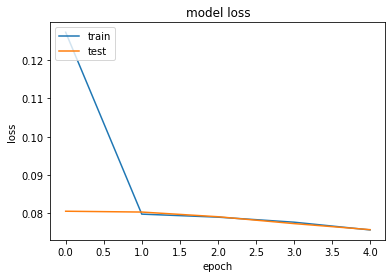

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
checkpoint_path = "training_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
model.save_weights(checkpoint_path.format(epoch=5))

In [ ]:
# model = RecommenderNet(num_users, num_products)
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
products = np.unique(df['product_id'])
products_enc = [[product2product_encoded.get(x)] for x in products]

In [ ]:
%%time
top_ratings_indices_list = []
k = 10

for i in test_pivot['user_id'][:10000].values:
    user_enc = user2user_encoded.get(i)
    user_product_array = np.hstack(
        ([[user_enc]] * len(products_enc), products_enc)
    )
    ratings = model.predict(user_product_array).flatten()
    top_ratings_indices_enc = ratings.argsort()[-k:][::-1]
    top_ratings_indices = [
        product_encoded2product.get(products_enc[x][0]) for x in top_ratings_indices_enc
    ]
    top_ratings_indices_list.append(top_ratings_indices)

Wall time: 1h 57s


In [ ]:
print_metrics(test_pivot['ground_truth'][:10000], top_ratings_indices_list, 10)

      metric     value
0  HitRate@k  0.247900
1      MAP@k  0.095903
2     NDCG@k  0.037399


In [ ]:
test_pivot_10000 = test_pivot.iloc[:10000].copy()

In [ ]:
test_pivot_10000['nn'] = top_ratings_indices_list

In [ ]:
test_pivot_10000.head()

,user_id,ground_truth,most_popular,svd,nn
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[196, 46149, 43154, 49235, 38928, 13176, 35951...","[24852, 44632, 27845, 36865, 11520, 38689, 294..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[47209, 24852, 47766, 33754, 45066, 4957, 1852...","[24852, 38544, 49683, 4210, 44632, 27845, 1157..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[47766, 21903, 9387, 22035, 43961, 16797, 5212...","[24852, 44632, 29447, 30233, 19660, 11576, 496..."
3,4,"[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[37646, 19057, 8174, 1940, 46969, 30233, 27344...","[24852, 13176, 29447, 38689, 27845, 47209, 115..."
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[26604, 40706, 8518, 31717, 21616, 11777, 2734...","[27845, 29447, 24852, 44632, 38689, 13176, 492..."


In [ ]:
test_pivot_10000.to_csv('data/test_pivot_10000.csv')

### ALS

In [ ]:
df_train_gb_new = df_train_gb.copy()
df_train_gb_new.head()

,user_id,product_id,rating
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [ ]:
items = np.unique(df_train_gb_new['product_id'].values)
item_to_encodeditem = {x: i for i, x in enumerate(items)}
df_train_gb_new['product_id_new'] = df_train_gb_new['product_id'].map(item_to_encodeditem)
encodeditem_to_item = {i: x for i, x in enumerate(items)}   

users = np.unique(df_train_gb_new['user_id'].values)
user_to_encodeduser = {x: i for i, x in enumerate(users)}
df_train_gb_new['user_id_new'] = df_train_gb_new['user_id'].map(user_to_encodeduser)
encodeduser_to_user = {i: x for i, x in enumerate(users)}

In [ ]:
sparse_item_user = csr_matrix((df_train_gb_new['rating'].astype(float), 
                               (df_train_gb_new['product_id_new'], df_train_gb_new['user_id_new'])))
sparse_user_item = csr_matrix((df_train_gb_new['rating'].astype(float), 
                               (df_train_gb_new['user_id_new'], df_train_gb_new['product_id_new'])))

In [ ]:
model_als = implicit.als.AlternatingLeastSquares(regularization=0.3, iterations=20)
model_als.fit(sparse_item_user)

In [ ]:
recommendations_ids_enc = model_als.recommend_all(sparse_user_item, filter_already_liked_items=False)

In [ ]:
recommendations_ids = [[encodeditem_to_item.get(j) for j in i] for i in recommendations_ids_enc]

In [ ]:
print_metrics(test_pivot['ground_truth'], recommendations_ids, 10)

      metric     value
0  HitRate@k  0.705406
1      MAP@k  0.356779
2     NDCG@k  0.219324


In [ ]:
test_pivot['als'] = recommendations_ids

In [ ]:
test_pivot.to_csv('data/test_pivot_mp_svd_als.csv')

In [ ]:
test_pivot = pd.read_csv('data/test_pivot_mp_svd_als.csv')
test_pivot = test_pivot.drop(labels=['Unnamed: 0'], axis=1)
test_pivot['ground_truth'] = test_pivot['ground_truth'].apply(eval)
test_pivot['most_popular'] = test_pivot['most_popular'].apply(eval)
test_pivot['svd'] = test_pivot['svd'].apply(eval)
test_pivot['als'] = test_pivot['als'].apply(eval)
test_pivot.head()

,user_id,ground_truth,most_popular,svd,als
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[196, 46149, 43154, 49235, 38928, 13176, 35951...","[13176, 196, 49235, 37710, 6184, 46149, 38928,..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[47209, 24852, 47766, 33754, 45066, 4957, 1852...","[33754, 13176, 18523, 24852, 4957, 33787, 4720..."
2,3,"[39190, 18599, 23650, 21903, 47766, 24810]","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[47766, 21903, 9387, 22035, 43961, 16797, 5212...","[21903, 47766, 16797, 42265, 21137, 43961, 496..."
3,4,"[26576, 25623, 21573]","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[37646, 19057, 8174, 1940, 46969, 30233, 27344...","[37646, 19057, 28204, 25146, 22825, 8174, 1074..."
4,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482...","[24852, 13176, 21137, 21903, 47209, 47766, 476...","[26604, 40706, 8518, 31717, 21616, 11777, 2734...","[26604, 40706, 8518, 11777, 21616, 31717, 2796..."


### Annoy KNN

In [ ]:
df_train_gb_new = df_train_gb.copy()
df_train_gb_new.head()

,user_id,product_id,rating
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [ ]:
items = np.unique(df_train_gb_new['product_id'].values)
item_to_encodeditem = {x: i for i, x in enumerate(items)}
df_train_gb_new['product_id_new'] = df_train_gb_new['product_id'].map(item_to_encodeditem)
encodeditem_to_item = {i: x for i, x in enumerate(items)}   

users = np.unique(df_train_gb_new['user_id'].values)
user_to_encodeduser = {x: i for i, x in enumerate(users)}
df_train_gb_new['user_id_new'] = df_train_gb_new['user_id'].map(user_to_encodeduser)
encodeduser_to_user = {i: x for i, x in enumerate(users)}

In [ ]:
sparse_user_item = csc_matrix((df_train_gb_new['rating'].astype(float), 
                               (df_train_gb_new['user_id_new'], df_train_gb_new['product_id_new'])), 
                                shape = (len(users), len(items)))

In [ ]:
embedding_size = 90
U, S, Vt = sparsesvd(sparse_user_item, embedding_size)
Ut = U.T

In [ ]:
%%time
annoy_index = AnnoyIndex(embedding_size, 'euclidean')
for i in range(len(Ut)):
    annoy_index.add_item(i, Ut[i])

Wall time: 2.14 s


In [ ]:
embedding_size, len(users)

(90, 206209)

In [ ]:
annoy_index.build(-1)
annoy_index.save('test.ann')

True

In [ ]:
annoy_index = AnnoyIndex(embedding_size, 'euclidean')
annoy_index.load('test.ann')

True

In [ ]:
%%time
n_neighbors = 7
nn_list = []
for i in range(len(users)):
    nn_enc = annoy_index.get_nns_by_item(i, n_neighbors)
    nn = [encodeduser_to_user.get(j) for j in nn_enc]
    nn_list.append(nn)

Wall time: 21.7 s


In [ ]:
nn_list[:3]

[[1, 205906, 52664, 28862, 85517, 187763, 111241],
 [2, 85197, 204422, 80026, 45801, 4391, 205746],
 [3, 129364, 113968, 73630, 66115, 35173, 38656]]

Рекомендации для первых 10000 пользователей с использованием информации о прошлых покупках пользователей (пользователь сам себе сосед)":

In [ ]:
%%time
recommendations_list = []
for i in nn_list[:10000]:
    df_tmp = df_train_gb_new[df_train_gb_new['user_id'].isin(i)].copy()
    df_tmp = df_tmp.groupby(['product_id'], as_index=False)['rating'].sum()
    df_tmp['rating'] = df_tmp['rating'] / n_neighbors
    recommendations = df_tmp.sort_values(by=['rating'], ascending=False)['product_id'][:10].values
    recommendations_list.append(recommendations)

Wall time: 18min 4s


In [ ]:
len(recommendations_list)

10000

In [ ]:
print_metrics(test_pivot['ground_truth'][:10000], recommendations_list, 10)

      metric     value
0  HitRate@k  0.720600
1      MAP@k  0.421925
2     NDCG@k  0.246440


Рекомендации для первых 10000 пользователей без использования информации о прошлых покупках пользователей (пользователь сам себе не сосед)":

In [ ]:
recommendations_list_2 = []
for i in nn_list[:10000]:
    df_tmp = df_train_gb_new[df_train_gb_new['user_id'].isin(i[1:])].copy()
    df_tmp = df_tmp.groupby(['product_id'], as_index=False)['rating'].sum()
    df_tmp['rating'] = df_tmp['rating'] / n_neighbors
    recommendations = df_tmp.sort_values(by=['rating'], ascending=False)['product_id'][:10].values
    recommendations_list_2.append(recommendations)

In [ ]:
print_metrics(test_pivot['ground_truth'][:10000], recommendations_list_2, 10)

      metric     value
0  HitRate@k  0.540600
1      MAP@k  0.378562
2     NDCG@k  0.162881
